# Preprocessing for Final Dataset
## Set up environment

In [1]:
import os
import pandas as pd
import numpy as np
import statistics
import re
from fuzzywuzzy import process, fuzz

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Initialize the stop words
stop_words = set(stopwords.words('english'))

# vectorizing the book info column using TFidf Vectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import KBinsDiscretizer

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/caseyhaseloff/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/caseyhaseloff/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/caseyhaseloff/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/caseyhaseloff/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Pull in required data:

In [2]:
path = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir) + "/data/")

os.listdir(path + 'raw/')

['BX-NewBooksUsers.csv',
 'BX-Books.csv',
 'BX-Ratings.csv',
 'BX-Users.csv',
 'BX-NewBooksRatings.csv',
 'BX-NewBooks.csv']

In [3]:
books = pd.read_csv(path + 'cleaned/BX-Books.csv')
users = pd.read_csv(path + 'cleaned/BX-Users.csv')
ratings = pd.read_csv(path + 'cleaned/BX-Ratings.csv')

In [4]:
books.head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Book-Publisher-Processed,Book-Title-Processed,Book-Info,Book-Vector,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded
0,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,richard bruce wright,harperflamingo canada,clara callan,clara callan by richard bruce wright,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8


In [5]:
ratings.head(1)

,User-ID,ISBN,Book-Rating
0,276744,038550120X,7


In [6]:
users.head(1)

,User-ID,User-City,User-State,User-Country,User-Age,Age-Group,User-Country-Encoded,Age-Group-Encoded
0,8,timmins,ontario,canada,41.0,"(34.0, 46.0]",17,2


## Discretize book ratings

array([[<Axes: title={'center': 'Book-Rating'}>]], dtype=object)

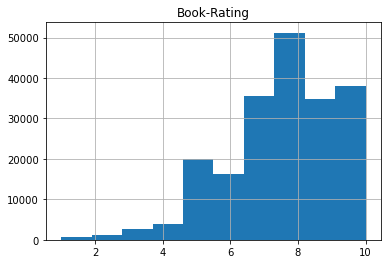

In [7]:
# ratings are skewed towards higher
# users are more likely to leave a nice review
ratings.hist('Book-Rating')

#### Create feature that states the popularity of a book:
Since some books have more reviews this will be taken into consideration for popularity. While also taking in the average rating of a book

In [8]:
df = ratings.merge(users)

In [9]:
df

,User-ID,ISBN,Book-Rating,User-City,User-State,User-Country,User-Age,Age-Group,User-Country-Encoded,Age-Group-Encoded
0,276744,038550120X,7,torrance,california,usa,23.0,"(4.0, 26.0]",124,0
1,276754,0684867621,8,alberta beach,alberta,canada,19.0,"(4.0, 26.0]",17,0
2,276755,0451166892,5,frankfurt am main,hessen,germany,32.0,"(26.0, 34.0]",41,1
3,276762,0380711524,5,duisburg,unknown,germany,25.0,"(4.0, 26.0]",41,0
4,276772,0553572369,7,bonn,unknown,germany,43.0,"(34.0, 46.0]",41,2
...,...,...,...,...,...,...,...,...,...,...
203958,276688,0892966548,10,fort lee,new jersey,usa,62.0,"(46.0, 100.0]",124,3
203959,276688,1551669315,6,fort lee,new jersey,usa,62.0,"(46.0, 100.0]",124,3
203960,276704,0345386108,6,cedar park,texas,usa,32.0,"(26.0, 34.0]",124,1
203961,276704,0743211383,7,cedar park,texas,usa,32.0,"(26.0, 34.0]",124,1


In [10]:
weighted_ratings = df.groupby(['ISBN', 'User-Country', 'User-Country-Encoded', 'Age-Group-Encoded', 'Age-Group']).agg(average_rating 
                                     = ('Book-Rating', 'mean'), times_read = ('User-ID', 'count'), average_age = ('User-Age', 'mean')) \
                                    .reset_index()

In [11]:
weighted_ratings

,ISBN,User-Country,User-Country-Encoded,Age-Group-Encoded,Age-Group,average_rating,times_read,average_age
0,0002005018,canada,17,0,"(4.0, 26.0]",8.000000,1,25.000000
1,0002005018,canada,17,1,"(26.0, 34.0]",7.666667,3,28.666667
2,0002005018,canada,17,2,"(34.0, 46.0]",7.000000,2,39.500000
3,0002005018,canada,17,3,"(46.0, 100.0]",7.000000,1,60.000000
4,0002005018,unknown,121,3,"(46.0, 100.0]",8.000000,1,72.000000
...,...,...,...,...,...,...,...,...
88884,9812327975,unknown,121,3,"(46.0, 100.0]",7.000000,1,72.000000
88885,9871138148,germany,41,1,"(26.0, 34.0]",9.000000,1,33.000000
88886,9871138148,portugal,89,2,"(34.0, 46.0]",9.000000,1,41.000000
88887,9871138148,spain,102,0,"(4.0, 26.0]",8.000000,2,20.000000


In [12]:
read_books = weighted_ratings.groupby('ISBN')['times_read'].sum()

# books that have more than 10 reviews - put quantile.
books_over = read_books[read_books > 10].index

In [13]:
weighted_ratings = weighted_ratings[weighted_ratings['ISBN'].isin(books_over)]

In [14]:
m = 3
# weighted_ratings = weighted_ratings[weighted_ratings['times_read'] > m]
weighted_ratings

,ISBN,User-Country,User-Country-Encoded,Age-Group-Encoded,Age-Group,average_rating,times_read,average_age
85,000649840X,australia,7,1,"(26.0, 34.0]",9.000000,1,32.000000
86,000649840X,australia,7,2,"(34.0, 46.0]",8.000000,1,39.000000
87,000649840X,canada,17,1,"(26.0, 34.0]",5.000000,2,29.500000
88,000649840X,hong kong,46,1,"(26.0, 34.0]",10.000000,1,34.000000
89,000649840X,netherlands,74,2,"(34.0, 46.0]",5.000000,1,36.000000
...,...,...,...,...,...,...,...,...
88775,8845205118,unknown,121,0,"(4.0, 26.0]",8.000000,1,26.000000
88776,8845205118,unknown,121,1,"(26.0, 34.0]",10.000000,1,31.000000
88797,884590184X,italy,55,0,"(4.0, 26.0]",5.750000,4,21.500000
88798,884590184X,italy,55,1,"(26.0, 34.0]",8.545455,11,29.545455


In [15]:
t = weighted_ratings['times_read']
a = weighted_ratings['average_rating']
c = ratings[ratings['ISBN'].isin(books_over)]['Book-Rating'].mean()

In [16]:
weighted_ratings['weighted_ratings'] = ((t*a/(t+m))) + ((m*c/(m+t)))

/var/folders/z5/2xfh619x3csdbh0bph8vb9100000gn/T/ipykernel_57827/1790009516.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weighted_ratings['weighted_ratings'] = ((t*a/(t+m))) + ((m*c/(m+t)))


In [17]:
weighted_ratings

,ISBN,User-Country,User-Country-Encoded,Age-Group-Encoded,Age-Group,average_rating,times_read,average_age,weighted_ratings
85,000649840X,australia,7,1,"(26.0, 34.0]",9.000000,1,32.000000,8.075719
86,000649840X,australia,7,2,"(34.0, 46.0]",8.000000,1,39.000000,7.825719
87,000649840X,canada,17,1,"(26.0, 34.0]",5.000000,2,29.500000,6.660575
88,000649840X,hong kong,46,1,"(26.0, 34.0]",10.000000,1,34.000000,8.325719
89,000649840X,netherlands,74,2,"(34.0, 46.0]",5.000000,1,36.000000,7.075719
...,...,...,...,...,...,...,...,...,...
88775,8845205118,unknown,121,0,"(4.0, 26.0]",8.000000,1,26.000000,7.825719
88776,8845205118,unknown,121,1,"(26.0, 34.0]",10.000000,1,31.000000,8.325719
88797,884590184X,italy,55,0,"(4.0, 26.0]",5.750000,4,21.500000,6.614697
88798,884590184X,italy,55,1,"(26.0, 34.0]",8.545455,11,29.545455,8.378777


array([[<Axes: title={'center': 'weighted_ratings'}>]], dtype=object)

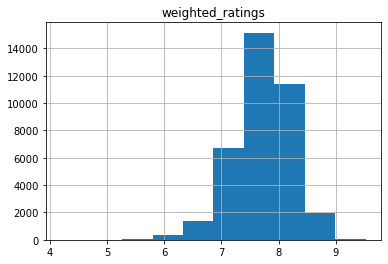

In [18]:
weighted_ratings.hist('weighted_ratings')

In [19]:
df = books.merge(weighted_ratings)

In [20]:
df.shape

(37141, 20)

In [21]:
df.sort_values('weighted_ratings', ascending = False).head(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Book-Publisher-Processed,Book-Title-Processed,Book-Info,Book-Vector,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded,User-Country,User-Country-Encoded,Age-Group-Encoded,Age-Group,average_rating,times_read,average_age,weighted_ratings
14175,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000.0,Scholastic,j k rowling,scholastic,harry potter and the goblet of fire book 4,harry potter and the goblet of fire book 4 by ...,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8,usa,124,0,"(4.0, 26.0]",9.636364,44,19.340909,9.517082
11815,0345339738,"The Return of the King (The Lord of the Rings,...",J.R.R. TOLKIEN,1986.0,Del Rey,j r r tolkien,del rey,the return of the king the lord of the ring pa...,the return of the king the lord of the ring pa...,[0. 0. 0. ... 0. 0. 0.],"(1979, 1989]",6,usa,124,1,"(26.0, 34.0]",9.750000,16,29.375000,9.436993
14361,043935806X,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003.0,Scholastic,j k rowling,scholastic,harry potter and the order of the phoenix book 5,harry potter and the order of the phoenix book...,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8,usa,124,0,"(4.0, 26.0]",9.519231,52,20.615385,9.423689
8638,0590353403,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,1998.0,Scholastic,j k rowling,scholastic,harry potter and the sorcerer s stone book 1,harry potter and the sorcerer s stone book 1 b...,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7,usa,124,2,"(34.0, 46.0]",9.625000,24,39.583333,9.418625
14176,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000.0,Scholastic,j k rowling,scholastic,harry potter and the goblet of fire book 4,harry potter and the goblet of fire book 4 by ...,[0. 0. 0. ... 0. 0. 0.],"(1999, 2009]",8,usa,124,1,"(26.0, 34.0]",9.515152,33,30.757576,9.369524


## Labelling weighted ratings:

array([[<Axes: title={'center': 'weighted_ratings'}>]], dtype=object)

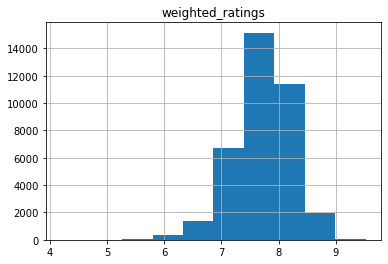

In [22]:
weighted_ratings.hist('weighted_ratings')

In [23]:
encoder = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')

In [24]:
ratings_discretized = encoder.fit_transform(df[['weighted_ratings']])

In [25]:
encoder.bin_edges_

array([array([4.20336529, 7.57571908, 8.05047939, 9.51708247])],
      dtype=object)

In [26]:
df['weighted_ratings_group_encoded'] = ratings_discretized.astype(int)

In [27]:
df.groupby(['weighted_ratings_group_encoded'])['ISBN'].count()

weighted_ratings_group_encoded
0    10548
1    14070
2    12523
Name: ISBN, dtype: int64

In [28]:
df.head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Book-Publisher-Processed,Book-Title-Processed,Book-Info,Book-Vector,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded,User-Country,User-Country-Encoded,Age-Group-Encoded,Age-Group,average_rating,times_read,average_age,weighted_ratings,weighted_ratings_group_encoded
0,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,amy tan,putnam pub group,the kitchen god s wife,the kitchen god s wife by amy tan,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7,malaysia,65,0,"(4.0, 26.0]",10.0,1,21.0,8.325719,2


In [29]:
df.to_csv(path + 'processed/processed_books.csv', index = False)